In [4]:
import numpy as np
import pandas as pd

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
df = pd.read_csv('../data/train.csv')

In [6]:
df.shape

(50000, 1252)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 1252 entries, id to stop_624
dtypes: int64(1252)
memory usage: 477.6 MB


In [8]:
df.columns

Index(['id', 'delta', 'start_0', 'start_1', 'start_2', 'start_3', 'start_4',
       'start_5', 'start_6', 'start_7',
       ...
       'stop_615', 'stop_616', 'stop_617', 'stop_618', 'stop_619', 'stop_620',
       'stop_621', 'stop_622', 'stop_623', 'stop_624'],
      dtype='object', length=1252)

Each row represents a game board, each game board is 25x25, so there are 625 tiles in total. Each board is randomly generated with some randomly chosen density between 1% (mostly 0) and 99% (mostly 1), and then allowed to run for 5 steps to 'warm up'. The resultant game board is the start board. The board is then advanced a random number of steps chosen between 1 and 5. 

The 'id' column is the game board identifier, an integer. The 'delta' column represents the number of steps from the 'start board' to the 'stop board', it is an integer between 1 and 5. 'start_0' is the value of row 1, column 1 of the start board, it is either 0 or 1 (dead or alive). 'start_1' is the value of row 1, column 2 of the start board. 'start_i' is the value of row (i // 25) + 1 and column (i % 25) + 1

In [9]:
# plot boards

# CNN

Idea here is to create a CNN without any dense layers to extract features and return a new image (the start board). 

In [10]:
from sklearn.model_selection import train_test_split

In [19]:
def process_data(df: pd.DataFrame, delta=1, test_size=0.3) -> (np.array, np.array, np.array, np.array):
    '''
    takes the train dataframe loaded above from the csv file, extracts those boards with delta steps, and 
    reshapes them to be the appropriate shape for CNN. Then returns a train test split.
    
    inputs: df is a pandas DataFrame with train data. delta is an integer between 1 and 5 (inclusive), default 1. 
            test_size denotes propertion of train data to go into a validation set, default 0.3
    outputs: multi-dimensional np.arrays, train are the train stop boards, y_train are the train start boards,
             val are the validation stop boards, y_val are the validation start boards
    '''
    len_data = df.loc[df['delta'] == 1, :].shape[0]
    stop_boards = df.loc[df['delta'] == 1, ['stop_{}'.format(i) for i in range(625)]].values.reshape(len_data, 25, 25, 1)
    start_boards = df.loc[df['delta'] == 1, ['start_{}'.format(i) for i in range(625)]].values.reshape(len_data, 25, 25, 1)
    train, val, y_train, y_val = train_test_split(stop_boards, start_boards, test_size=test_size, random_state=42)
    return train, val, y_train, y_val

In [20]:
train, val, y_train, y_val = process_data(df)

In [21]:
print(train.shape)
print(val.shape)
print(y_train.shape)
print(y_val.shape)

(7079, 25, 25, 1)
(3034, 25, 25, 1)
(7079, 25, 25, 1)
(3034, 25, 25, 1)


In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from tensorflow.keras.models import Sequential

In [91]:
model = Sequential()

loss = tf.losses.BinaryCrossentropy(from_logits=True)


model.add(Conv2D(filters=64, kernel_size=7, padding='same', input_shape=(25, 25, 1)))
#model.add(Conv2D(filters=128, kernel_size=5, padding='same', input_shape=(25, 25, 64)))
#model.add(Conv2D(filters=128, kernel_size=3, padding='same', input_shape=(25, 25, 128)))
#model.add(Conv2D(filters=64, kernel_size=3, padding='same', input_shape=(25, 25, 128)))
model.add(Conv2D(filters=1, kernel_size=3, padding='same', input_shape=(25, 25, 64)))
model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])

In [95]:
class_weight = {0: 1.,
                1: 6.
               }
model.fit(x=train, y=y_train, epochs=3, verbose=1, validation_data=(val, y_val), class_weight=class_weight)

ValueError: `class_weight` not supported for 3+ dimensional targets.

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
def compare_preds(val, y_val, model, i):
    '''
    takes the ith stop board of the val, predicts the start board of it using the CNN model and plots it. 
    Plots the actual start board for comparison
    
    Inputs: val is a np.array of validation stop boards; y_val is an np.array of validation start boards;
            model is a trained CNN model as above; i is an index, integer between 0 and len(val) - 1
    Outputs: plots the prediced board, i.e. model(val[i]) alongside the actual stop board, i.e. y_val[i]
    '''
    pred = model.predict_classes(val)[i]
    pred = pred.reshape(25, 25)
    actual = y_val[i].reshape(25, 25)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 8))
    ax[0].imshow(pred, cmap='gray_r')
    ax[0].set_title("Predicted start board")
    ax[1].imshow(actual, cmap='gray_r')
    ax[1].set_title("Actual start board")

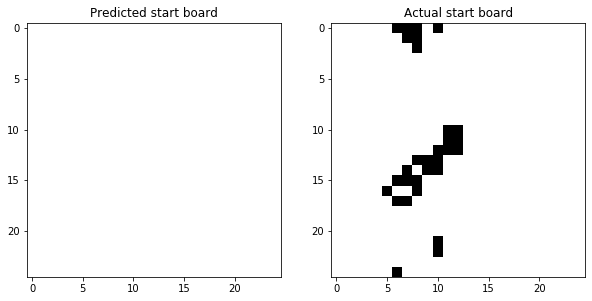

In [93]:
compare_preds(val, y_val, model, 6)